<a href="https://colab.research.google.com/github/andreaaraldo/machine-learning-for-networks/blob/master/06.clustering-and-anomaly/06.c.autoencoders.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random

from sklearn.model_selection import GridSearchCV
from sklearn.metrics import average_precision_score, precision_score, \
                        recall_score, precision_recall_curve, roc_curve, \
                        roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.preprocessing import StandardScaler



# I prepared these libraries for you
! wget https://raw.githubusercontent.com/andreaaraldo/machine-learning-for-networks/master/course_library/andrea_models.py
! wget https://raw.githubusercontent.com/andreaaraldo/machine-learning-for-networks/master/course_library/visualization.py
from andrea_models import subsample
from visualization import silhouette_diagram, plot_conf_mat, \
                      false_positive_rate, evaluate_anomaly_detector

import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger, TensorBoard



# The following is to be able to mount Google Drive
from google.colab import drive

import os
import datetime
import shutil



# The following library is to plot the loss during training
# https://github.com/stared/livelossplot
! pip install livelossplot
from livelossplot import PlotLossesKerasTF


# To show time at each cell
# Credits to https://medium.com/@arptoth/how-to-measure-execution-time-in-google-colab-707cc9aad1c8
!pip install ipython-autotime 
%load_ext autotime

--2020-04-07 07:49:10--  https://raw.githubusercontent.com/andreaaraldo/machine-learning-for-networks/master/course_library/andrea_models.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3190 (3.1K) [text/plain]
Saving to: ‘andrea_models.py.1’

andrea_models.py.1  100%[===================>]   3.12K  --.-KB/s    in 0s      

2020-04-07 07:49:10 (69.8 MB/s) - ‘andrea_models.py.1’ saved [3190/3190]

--2020-04-07 07:49:11--  https://raw.githubusercontent.com/andreaaraldo/machine-learning-for-networks/master/course_library/visualization.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP reque

### Mount google drive

In [14]:
mount_point = '/content/gdrive' # Always the same, don't change it
drive.mount(mount_point, force_remount=True)
drive_path = mount_point + '/My Drive/' # Always the same, don't change it
my_path = drive_path + \
  'tsp/teaching/data-science-for-networks/img-from-code/06.clustering-and-anomaly/'

Mounted at /content/gdrive
time: 1.57 s


### Preprocessing

The following code is the same as in the [previous notebook](https://github.com/andreaaraldo/machine-learning-for-networks/blob/master/06.clustering-and-anomaly/06.a.kmeans-anomaly.ipynb).

In [15]:
np.random.seed(9)
random.seed(9)

! wget https://datahub.io/machine-learning/creditcard/r/creditcard.csv

df = pd.read_csv('creditcard.csv')
df.head()

df.info(verbose=True)
df['Class'].value_counts()
num_of_normal = sum( df['Class']=="'0'" )
num_of_anomalies = sum( df['Class']=="'1'" )
num_of_anomalies/num_of_normal

df = df.drop('Time', axis=1)
X = df.drop('Class', axis=1)
y = [1 if c=="'1'" else 0 for c in df['Class']] 

--2020-04-07 07:49:20--  https://datahub.io/machine-learning/creditcard/r/creditcard.csv
Resolving datahub.io (datahub.io)... 104.18.48.253, 104.18.49.253, 2606:4700:3031::6812:30fd, ...
Connecting to datahub.io (datahub.io)|104.18.48.253|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://pkgstore.datahub.io/machine-learning/creditcard/creditcard_csv/data/ebdc64b6837b3026238f3fcad3402337/creditcard_csv.csv [following]
--2020-04-07 07:49:21--  https://pkgstore.datahub.io/machine-learning/creditcard/creditcard_csv/data/ebdc64b6837b3026238f3fcad3402337/creditcard_csv.csv
Resolving pkgstore.datahub.io (pkgstore.datahub.io)... 104.18.48.253, 104.18.49.253, 2606:4700:3031::6812:30fd, ...
Connecting to pkgstore.datahub.io (pkgstore.datahub.io)|104.18.48.253|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 151114991 (144M) [text/csv]
Saving to: ‘creditcard.csv.1’

creditcard.csv.1    100%[===================>] 144.11M   160MB/s    in

As always, we should always ahuffle the dataset

In [16]:
X, y = shuffle(X, y)

time: 114 ms


We also scale the dataset.

In [17]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

time: 155 ms


# Autoencoder build and training

Let's write the functions to build and train the model, similar to what we did in our [Neural Network's notebook](https://github.com/andreaaraldo/machine-learning-for-networks/blob/master/04.neural_networks/neural_networks.ipynb).

In [18]:
n_features = X_scaled.shape[1]
print("The number of features is ", n_features)
act_fun = 'tanh'

The number of features is  29
time: 2.67 ms


In [0]:


def build_model():

  model = Sequential([
      Dense(10, input_dim = n_features, activation=act_fun), # Encoder
      Dense(5, activation=act_fun), ### Latent representation
      Dense(10, activation=act_fun), # Decoder
      Dense(n_features, activation=act_fun) # Decoder
  ])


  model.compile(loss='mean_squared_error', optimizer='adam')

  return model

time: 3.49 ms


In [9]:
def train_model(nn_file, X_tr, y_tr, epochs, overwrite=False):
  """
  nn_file:  Before training, the model contained in this file will be loaded
            After training, the resulting model will be written in this file

  
  overwrite: If true, the model will be built and trained from scratch
  """

  ###################################
  #### CALLBACKS ####################
  ###################################
  plot_cb = PlotLossesKerasTF() # Plots the loss during training
  checkpoint_cb = ModelCheckpoint(nn_file) # Stores weights
  logger_cb = CSVLogger(nn_file+'.csv', append=True) # Stores history


  if overwrite==True:
    os.remove(nn_file)
    os.remove(nn_file+'.csv')

  if not os.path.isfile(nn_file):
    model = build_model()
  else:
    model = load_model(nn_file)

  history = model.fit(X_tr, y_tr, epochs=epochs,
                      callbacks=[plot_cb, checkpoint_cb, logger_cb],
                      validation_split=0.2)
  
  return model

time: 6.43 ms


Let's now build and train our first autoencoder. Note that the X and Y are the same, since we want to train the NN to be able to reconstruct the input.

In the tensor board, select "Scalars"

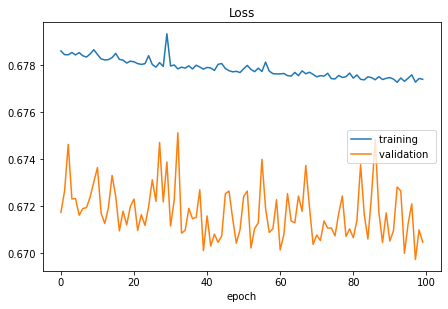

Loss
	training         	 (min:    0.677, max:    0.682, cur:    0.677)
	validation       	 (min:    0.670, max:    0.677, cur:    0.670)
7121/7121 [==============================] - 16s 2ms/step - loss: 0.6774 - val_loss: 0.6705
time: 26min 34s


In [0]:
nn_file = my_path + 'nn1.h5'

model = train_model(nn_file, X_scaled, X_scaled, epochs=100)



The loss remains too high

==> Clear sign of underfitting

==> We expect bad precision-recall and ROC curves

# Tune the Precision-Recall curve and the ROC curve

The **anomaly score** of each sample is the reconstruction error.
To fix a threshold above which the sample is considered anomaly, we plot precision-recall and ROC curves. We need ground truth to do so. Therefore, to avoid **data leakage**, we decide the threshold on the training set and verify its performance on the test set. This is similar to our [previous notebook](https://github.com/andreaaraldo/machine-learning-for-networks/blob/master/06.clustering-and-anomaly/06.b.isolation-forest.ipynb), we separate training and test set.

In [19]:
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.5)


time: 157 ms


In [20]:
X_tr_reconstr = model.predict(X_train)
anomaly_scores = np.linalg.norm(X_tr_reconstr - X_train, axis=1)

time: 3.03 s


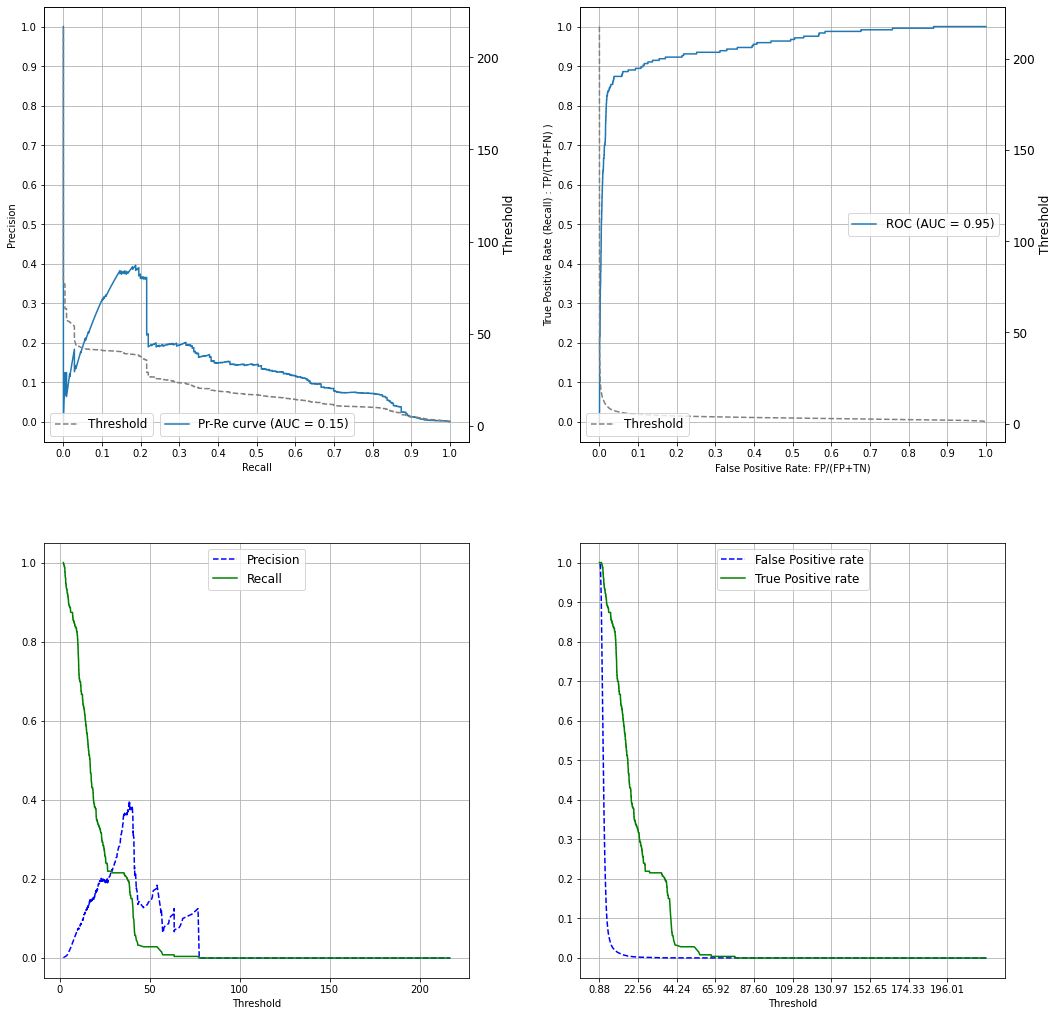

time: 1.2 s


In [0]:
evaluate_anomaly_detector(y_train, anomaly_scores)

# Solve the underfitting

We may be compressing information too much. We need to allow the model to better adapt to the input data, by increasing the encoding layer

In [0]:
def build_model():

  model = Sequential([
      Dense(20, input_dim = n_features, activation=act_fun), # Encoder
      Dense(10, activation=act_fun), ### Latent representation
      Dense(20, activation=act_fun), # Decoder
      Dense(n_features, activation=act_fun) # Decoder
  ])


  model.compile(loss='mean_squared_error', optimizer='adam')

  return model

time: 5.5 ms


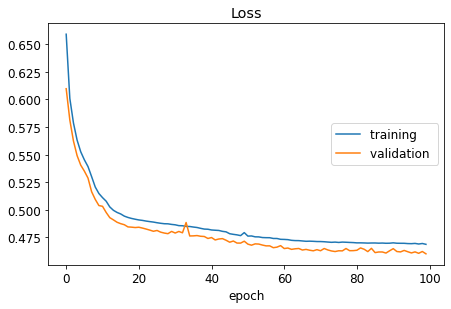

Loss
	training         	 (min:    0.469, max:    0.682, cur:    0.469)
	validation       	 (min:    0.460, max:    0.677, cur:    0.460)
7121/7121 [==============================] - 16s 2ms/step - loss: 0.4687 - val_loss: 0.4601
time: 26min 25s


In [0]:
nn_file = my_path + 'nn2.h5'

model = train_model(nn_file, X_scaled, X_scaled, epochs=100)


We reduced the loss, but it is still high

In [0]:
X_tr_reconstr = model.predict(X_train)
anomaly_scores = np.linalg.norm(X_tr_reconstr - X_train, axis=1)

time: 2.72 s


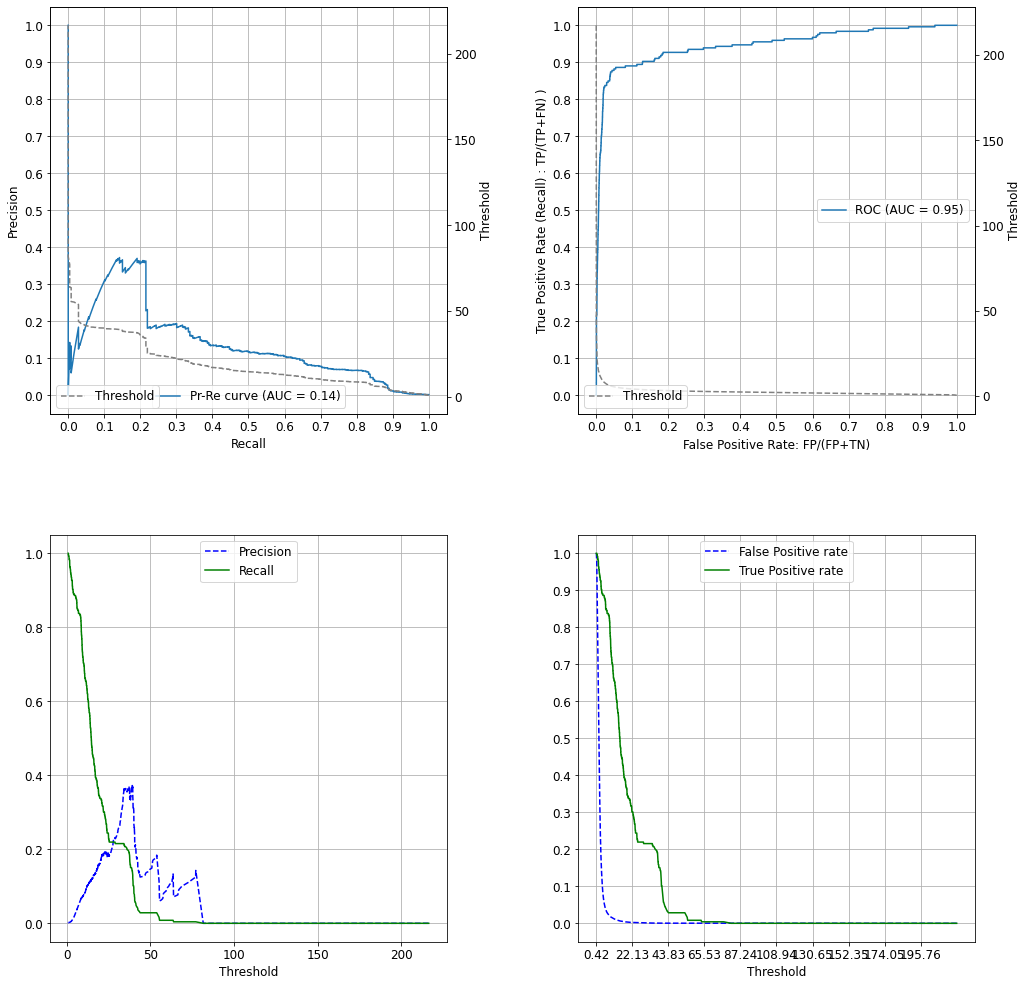

time: 1.2 s


In [0]:
evaluate_anomaly_detector(y_train, anomaly_scores)

# Deeper autoencoder

To solve underfitting, we need to make the model more flexible, i.e., more complex. We have tried to increase the encoding layer. Now, we try also to increase the depth, i.e., the numbr of layers.

In [0]:
def build_model():

  model = Sequential([
      Dense(20, input_dim = n_features, activation=act_fun), # Encoder
      Dense(15, activation=act_fun), # Encoder
      Dense(10, activation=act_fun), ### Latent representation
      Dense(15, activation=act_fun), # Decoder
      Dense(20, activation=act_fun), # Decoder
      Dense(n_features, activation=act_fun) # Decoder
  ])


  model.compile(loss='mean_squared_error', optimizer='adam')

  return model

time: 4.17 ms


Google interrupted my run and raised an error. Fortunately, the callbacks saved the status of the NN at every epoch.

The easiest way to recover the NN trained before the error is to add few training epochs.

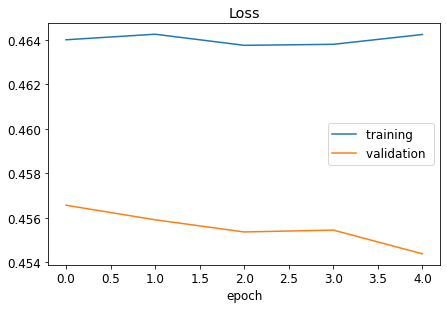

Loss
	training         	 (min:    0.464, max:    0.682, cur:    0.464)
	validation       	 (min:    0.454, max:    0.677, cur:    0.454)
7121/7121 [==============================] - 17s 2ms/step - loss: 0.4642 - val_loss: 0.4544
time: 1min 26s


In [0]:
nn_file = my_path + 'nn3.h5'

model = train_model(nn_file, X_scaled, X_scaled, epochs=5)


Let's plot the entire training history

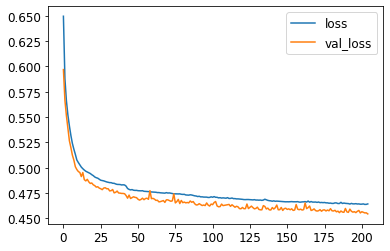

time: 169 ms


In [0]:
def plot_train_hist(csv_hist_file):
  hist_df = pd.read_csv(csv_hist_file)
  hist_df[['loss', 'val_loss']].plot()

plot_train_hist(nn_file+'.csv')

We reduced the loss, but not that much.

# Even larger encoding layer

In [7]:
def build_model():

  model = Sequential([
      Dense(27, input_dim = n_features, activation=act_fun), # Encoder
      Dense(24, activation=act_fun), # Encoder
      Dense(20, activation=act_fun), ### Latent representation
      Dense(24, activation=act_fun), # Decoder
      Dense(27, activation=act_fun), # Decoder
      Dense(n_features, activation=act_fun) # Decoder
  ])


  model.compile(loss='mean_squared_error', optimizer='adam')

  return model

time: 3.59 ms


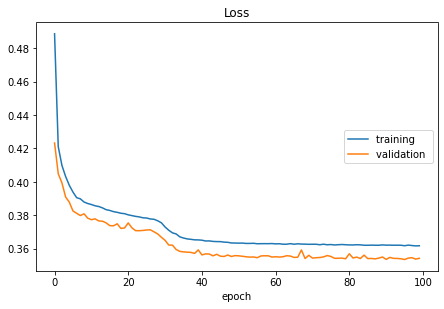

Loss
	training         	 (min:    0.362, max:    0.489, cur:    0.362)
	validation       	 (min:    0.354, max:    0.423, cur:    0.354)
7121/7121 [==============================] - 17s 2ms/step - loss: 0.3618 - val_loss: 0.3543
time: 29min 47s


In [10]:
nn_file = my_path + 'nn4.h5'

model = train_model(nn_file, X_scaled, X_scaled, epochs=100)

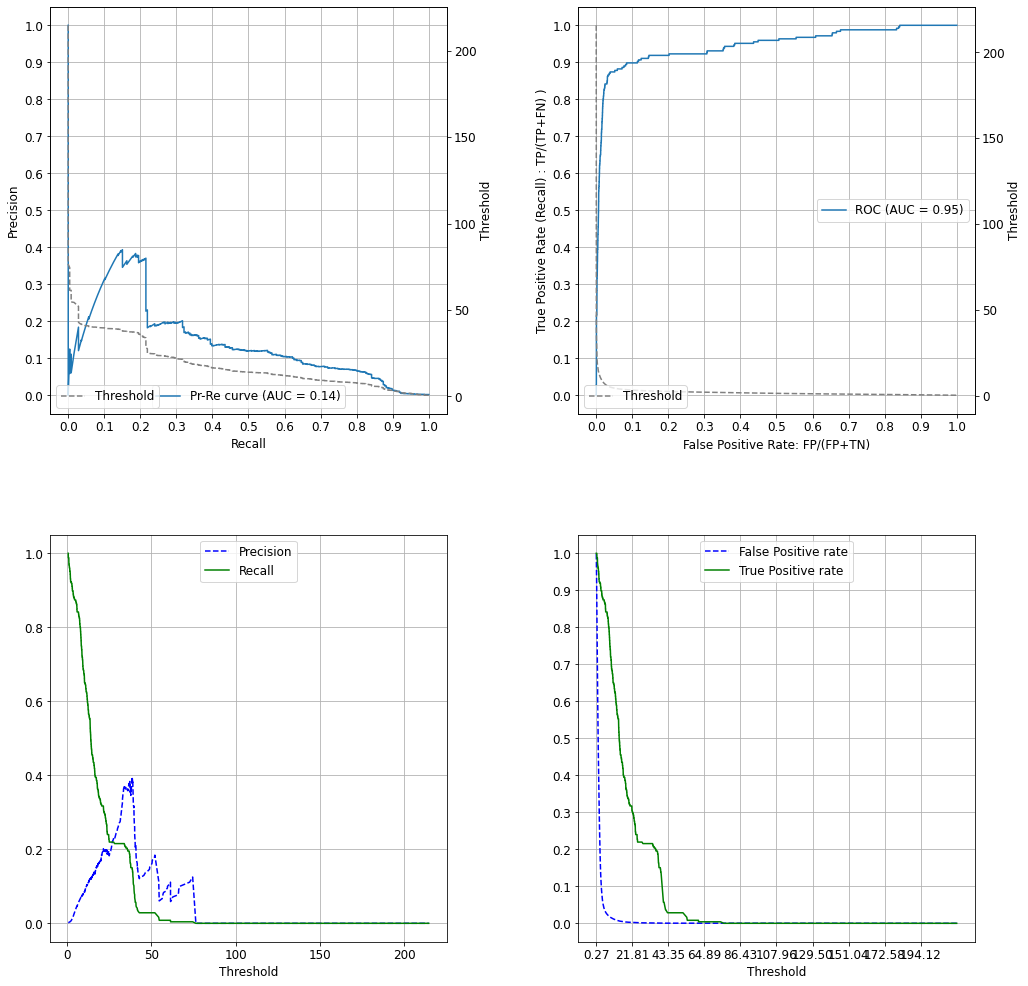

time: 4.17 s


In [24]:
X_tr_reconstr = model.predict(X_train)
anomaly_scores = np.linalg.norm(X_tr_reconstr - X_train, axis=1)

evaluate_anomaly_detector(y_train, anomaly_scores)

# 23-neurons encoding layer

We observe that the training loss is still high and the curves could be improved. Let's try to give more flexibility to the middle layer

In [27]:
def build_model():

  model = Sequential([
      Dense(27, input_dim = n_features, activation=act_fun), # Encoder
      Dense(25, activation=act_fun), # Encoder
      Dense(23, activation=act_fun), ### Latent representation
      Dense(25, activation=act_fun), # Decoder
      Dense(27, activation=act_fun), # Decoder
      Dense(n_features, activation=act_fun) # Decoder
  ])


  model.compile(loss='mean_squared_error', optimizer='adam')

  return model

time: 4.72 ms


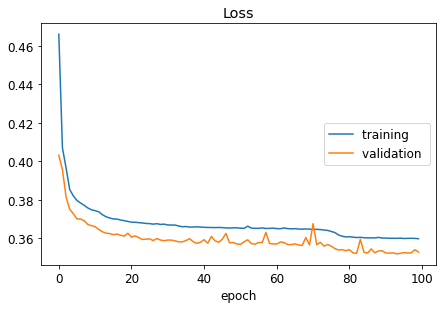

Loss
	training         	 (min:    0.360, max:    0.489, cur:    0.360)
	validation       	 (min:    0.352, max:    0.423, cur:    0.353)
7121/7121 [==============================] - 18s 2ms/step - loss: 0.3597 - val_loss: 0.3528
time: 29min 17s


In [28]:
nn_file = my_path + 'nn5.h5'

model = train_model(nn_file, X_scaled, X_scaled, epochs=100)

We did not improve a lot

# Different activation function

In [33]:
act_fun = 'linear'

time: 646 µs
ERROR! Session/line number was not unique in database. History logging moved to new session 59


In [34]:
def build_model():

  model = Sequential([
      Dense(27, input_dim = n_features, activation=act_fun), # Encoder
      Dense(25, activation=act_fun), # Encoder
      Dense(23, activation=act_fun), ### Latent representation
      Dense(25, activation=act_fun), # Decoder
      Dense(27, activation=act_fun), # Decoder
      Dense(n_features, activation=act_fun) # Decoder
  ])


  model.compile(loss='mean_squared_error', optimizer='adam')

  return model

time: 3.22 ms


In [0]:
nn_file = my_path + 'nn7.h5'

model = train_model(nn_file, X_scaled, X_scaled, epochs=100)

Epoch 1/100
7107/7121 [============================>.] - ETA: 0s - loss: 0.4661

# Other examples of Autoencoders for anomaly detection

* Application of autoencoders to the same dataset: Ch.8 of A. Patel, Hands-on unsupervised learning using Python, O'Reilly, 2019
* [Handwritten digits](https://visualstudiomagazine.com/articles/2019/03/01/neural-anomaly-detection-using-keras.aspx)